In [245]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

In [246]:
import pims
import pySPM as spm 
import trackpy as tp
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        self.filenames = glob.glob(filename_pattern)
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_plane().pixels for s in self.scans])
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype

if True:
    frames = SXMReader("data_high_density/*.sxm")
    molecule_size = 13
    min_mass = 5.0
    min_size = 3.0
    max_ecc = 0.3
if False:
    frames = SXMReader("data_hole_closing/*.sxm")
    molecule_size = 9 
    min_mass = 2.0
    min_size = 1.0
    max_ecc = 0.3

#print(frames[0])
    
#plt.imshow(frames[7])

In [247]:
"""
f = tp.locate(frames[7], molecule_size, minmass=1)
tp.annotate(f, frames[7])

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
"""

f = tp.batch(frames[:], molecule_size, minmass=1)
#tp.quiet()  # Turn off progress reports for best performance

Frame 7: 58 features


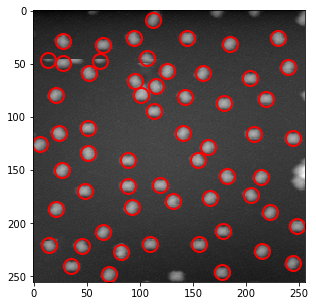

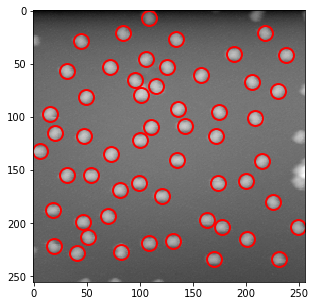

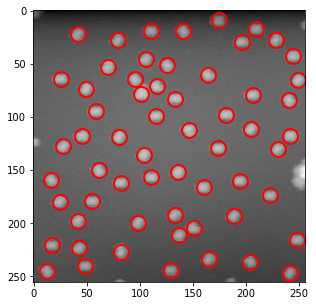

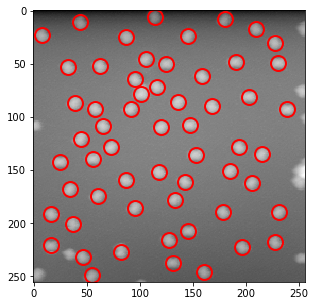

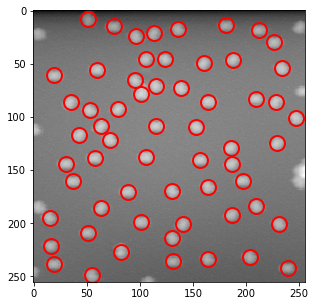

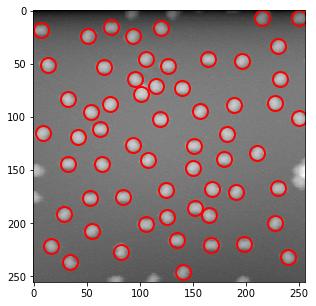

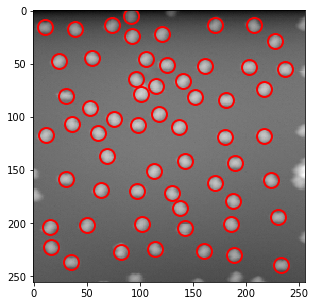

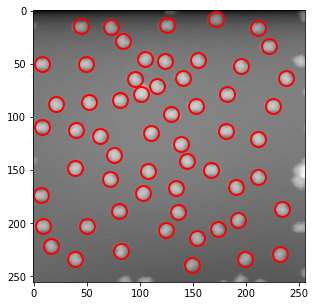

In [248]:
plt.figure()

for i,frame in enumerate(frames):
    tp.annotate(f[f['frame']==i], frame)

Frame 7: 58 trajectories present.


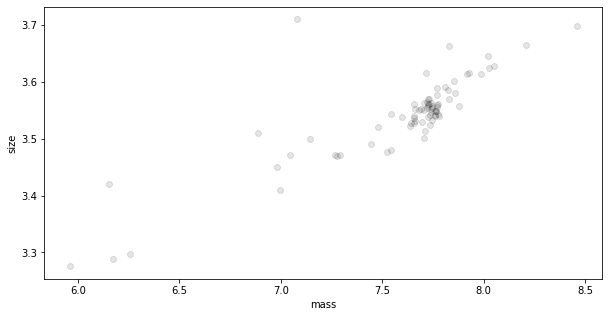

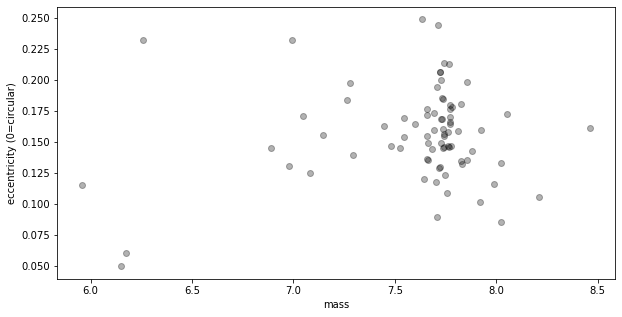

In [249]:
t = tp.link(f, search_range=50, adaptive_stop=5, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [250]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc))]
t2 = tp.filter_stubs(t, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 78
After: 78


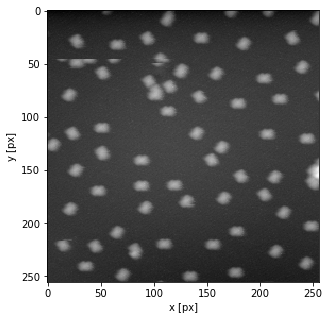

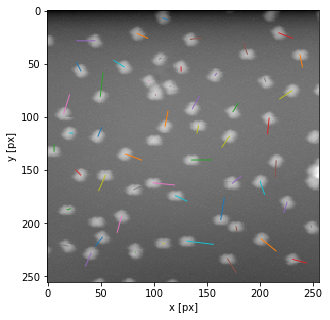

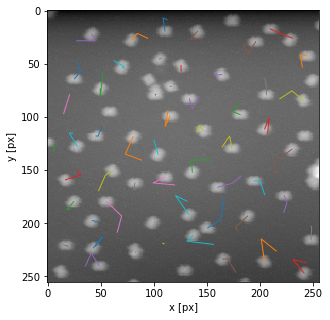

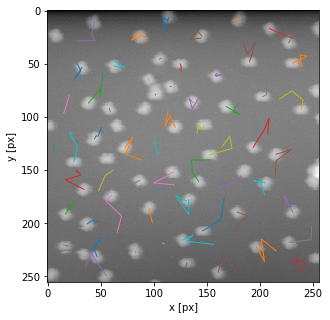

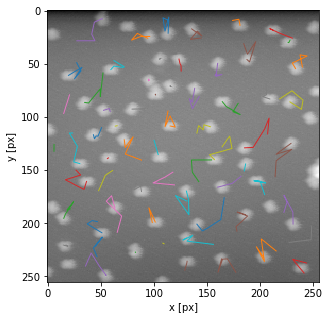

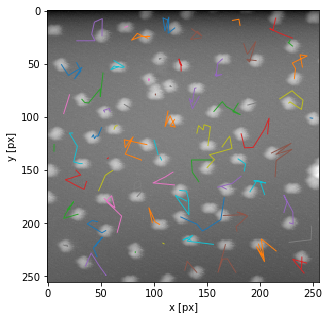

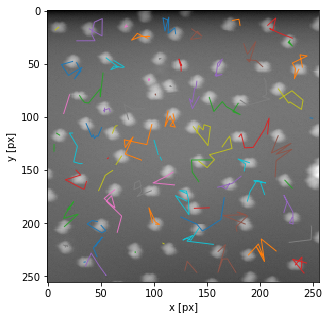

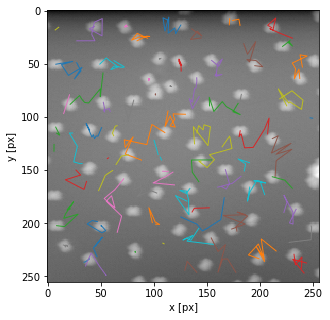

In [251]:
for i,frame in enumerate(frames):
    tp.plot_traj(t2[t2['frame']<=i], superimpose=frame);

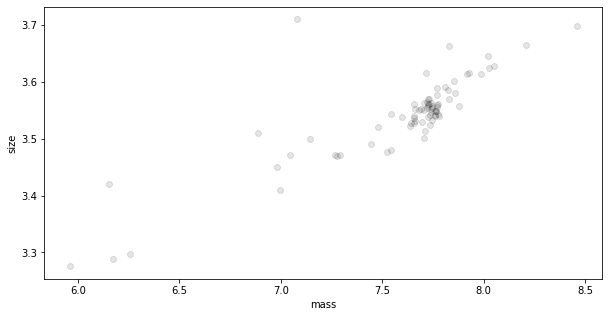

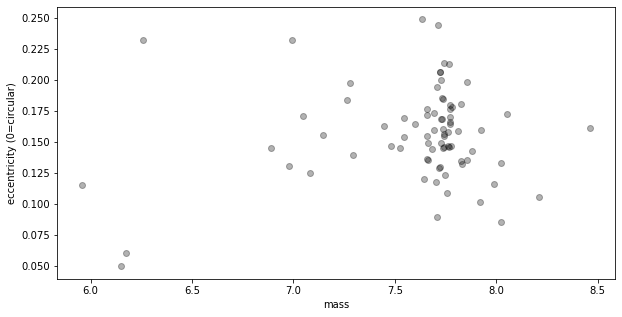

In [252]:
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [253]:
plt.figure()
#tp.plot_traj(t2, superimpose=frames[0]);
#tp.plot_traj(t2[t2['particle']==37], superimpose=frames[0]);

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

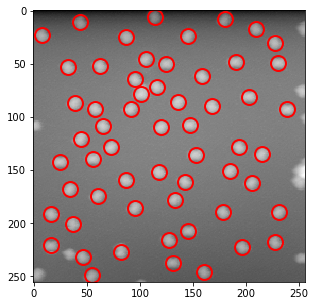

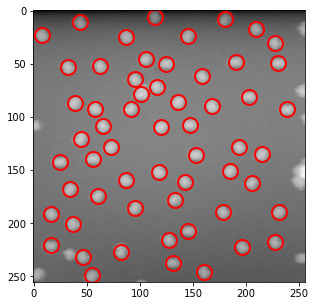

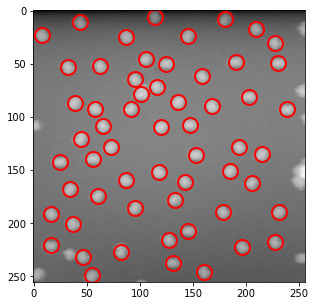

In [254]:
frame_n=3
tp.annotate(f[f['frame'] == frame_n], frames[frame_n])
tp.annotate(t1[t1['frame'] == frame_n], frames[frame_n])
tp.annotate(t2[t2['frame'] == frame_n], frames[frame_n])

In [255]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
print(d)

              y         x
frame                    
1     -0.830792 -2.472621
2      0.442774 -1.476635
3      2.243976 -3.107985
4      2.219635 -2.829990
5      2.372913 -3.834420
6      0.411859 -4.488371
7     -0.398408 -4.866058


bad: [13, 17, 18, 22, 37, 43, 46, 55, 57, 61, 62, 64, 68]


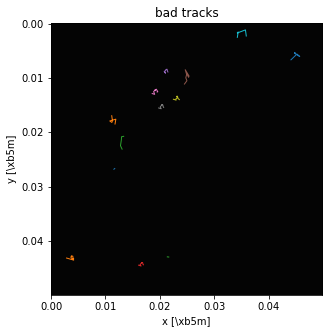

good: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 65, 66, 67, 69, 70, 72, 73, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 59, 60, 65, 66, 67, 69, 70, 72, 73]


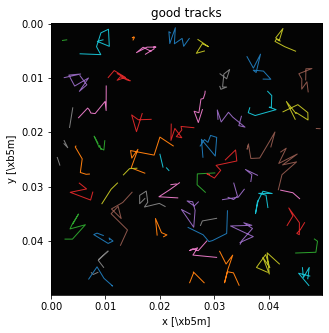

                    0         1         2             3         4         5   \
lag time [s]                                                                   
1.0           0.000004  0.000010  0.000006  7.687036e-06  0.000004  0.000009   
2.0           0.000003  0.000016  0.000014  7.120381e-06  0.000008  0.000009   
3.0           0.000007  0.000028  0.000016  6.168099e-06  0.000005  0.000015   
4.0           0.000007  0.000033       NaN  9.685077e-06  0.000007  0.000019   
5.0           0.000011  0.000039       NaN  2.372720e-07  0.000007  0.000020   
6.0           0.000014  0.000064       NaN  4.707778e-06  0.000005  0.000039   
7.0           0.000013  0.000052       NaN           NaN  0.000005  0.000048   

                    6         7         8         9   ...        58  \
lag time [s]                                          ...             
1.0           0.000006  0.000003  0.000004  0.000005  ...  0.000006   
2.0           0.000013  0.000007  0.000015  0.000007  ...  0.00000

In [256]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
def is_track_good(track):
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) > (2.0e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#im = im.T[movement_filter].T 
print(im)

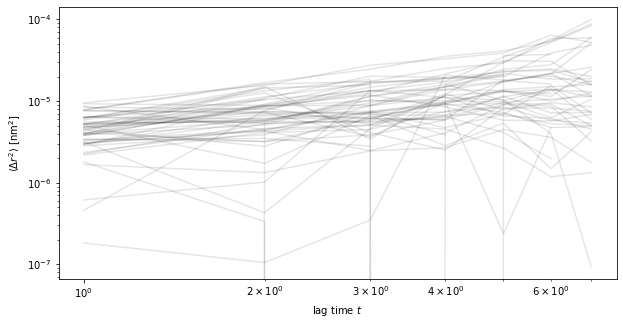

In [257]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

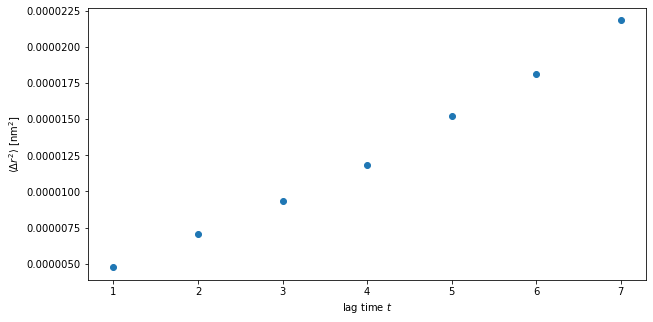

In [258]:
em = tp.emsd(tm, frames.meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));
fig.savefig('diffusion.png')

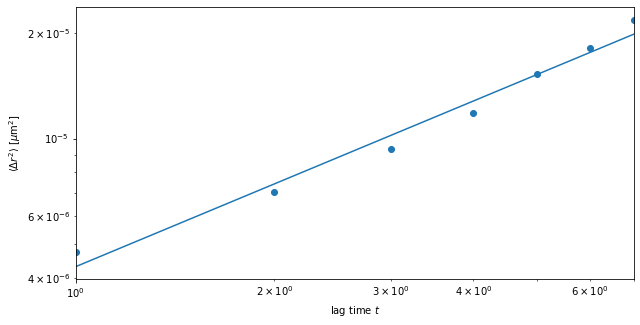

,n,A
msd,0.784952,0.000004


In [259]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]